# Choose a business to fund in Trentino-Alto Adige

In [15]:
import numpy as np 
import pandas as pd
import json
import geocoder # to get coordinates
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium
print("Libraries imported.")

# Better image quality in the notebook
%config InlineBackend.figure_format = 'svg'

Libraries imported.


In [16]:
map = folium.Map(location=[46.71503, 11.65598], zoom_start=9)
map

### Find coordinates and population of these towns and make a table

In [17]:
coords = pd.DataFrame({'Town': ['Bressanone','Brunico','Chiusa','Merano','Vipiteno', 'Bolzano',], 
                       'Latitude': [46.71503, 46.79942, 46.6399237, 46.6681700, 46.89313, 46.500000,],
                      'Longitude': [11.65598, 11.93429, 11.5663497, 11.1595300, 11.42961, 11.350000,],
                      'Population': [21688, 16356, 5215, 40047, 6875, 108245,]})
coords 

Town   Latitude  Longitude  Population
0  Bressanone  46.715030   11.65598       21688
1     Brunico  46.799420   11.93429       16356
2      Chiusa  46.639924   11.56635        5215
3      Merano  46.668170   11.15953       40047
4    Vipiteno  46.893130   11.42961        6875
5     Bolzano  46.500000   11.35000      108245

### Automate and send request to Foursquare:

In [18]:
# Automate requests to Foursquare: 

# Functions to render JSON to Dataframe
def get_names(json):
    name = []
    for i in json['response']['groups'][0]['items']:
        for j in i:
            j = i['venue']['name']
        name.append(j)
    return name
def get_coordinates(json):
    lat = []
    long = []
    for i in json['response']['groups'][0]['items']:
        lt = i['venue']['location']['lat']
        lg = i['venue']['location']['lng']
        lat.append(lt)
        long.append(lg)
    return lat, long
def get_category(json):
    category = []
    for i in json['response']['groups'][0]['items']:
        for j in i:
            if len(i['venue']['categories'])==0:
                j='Hotel'
            else:
                j = i['venue']['categories'][0]['name']
        category.append(j)
    return category

# 1st request
CLIENT_ID = 'WDKKEXPHHDF24SAZF5F5WKHOXGICZO2BRFR1OZJJDZFOXH0S'
CLIENT_SECRET = 'DFX3JTACMOPP33O1KEHXNDON55TOZOCO45BAOD2NBGXG5YVF'
VERSION = '20200916'
LIMIT = 500
radius = 5000
request_url1 = []
query = ['food', 'drink', 'tourist', 'hotel', 'ski']
for i, row in coords.iterrows():
    for j in query:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            row['Latitude'], 
            row['Longitude'], 
            radius, 
            LIMIT,
            j)
        request_url1.append(url)

# 2nd request
LIMIT = 500
radius = 8000
request_url2 = []
for i, row in coords.iterrows():
    for j in query:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            row['Latitude'], 
            row['Longitude'], 
            radius, 
            LIMIT,
            j)
        request_url2.append(url)

# Sending requests:
res1 = []
for i in range(len(request_url1)):   
    res1.append(requests.get(request_url1[i]).json())
print('Got: {} JSONs after 1st request to Foursquare'.format((len(res1))))

res2 = []
for i in range(len(request_url2)):   
    res2.append(requests.get(request_url2[i]).json())
print('Got: {} JSONs after 2nd request to Foursquare'.format((len(res2))))
print('If there is a Key Error try launch the cell again. It\'s a Foursquare failed response')    

# 1st Dataframe
df1 = pd.DataFrame({'Town': {},
                    'Venue': {}, 
                    'Latitude': {}, 
                    'Longitude': {}, 
                    'Category': {}})
   
for m in [0, len(res1), len(query)]:
    for j in range(len(coords['Town'])):
        for z in range(len(query)):
            town = coords['Town'][j]
            name = get_names(res1[z+m])
            coordinates = get_coordinates(res1[z+m])
            categories = get_category(res1[z+m])
            latitude = coordinates[0]
            longitude = coordinates[1]
            dfa = pd.DataFrame({'Town': town,
                                'Venue': name,
                                'Latitude': latitude, 
                                'Longitude': longitude, 
                                'Category': categories})
            df1 = pd.concat([df1, dfa], sort=True, axis=0)
        m+=5
    break

# 2nd Dataframe
df2 = pd.DataFrame({'Town': {},
                    'Venue': {}, 
                    'Latitude': {}, 
                    'Longitude': {}, 
                    'Category': {}})
   
for m in [0, len(res2), len(query)]:
    for j in range(len(coords['Town'])):
        for z in range(len(query)):
            town = coords['Town'][j]
            name = get_names(res2[z+m])
            coordinates = get_coordinates(res2[z+m])
            categories = get_category(res2[z+m])
            latitude = coordinates[0]
            longitude = coordinates[1]
            dfb = pd.DataFrame({'Town': town,
                                'Venue': name,
                                'Latitude': latitude, 
                                'Longitude': longitude, 
                                'Category': categories})
            df2 = pd.concat([df2, dfb], sort=True, axis=0)
        m+=len(query)
    break
    
# Global Dataframe
df = pd.concat([df1, df2], sort=True, axis=0)
df.drop_duplicates(['Venue', 'Latitude', 'Longitude'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index', axis=1, inplace=True)
print('These are venues \nin 6 towns in 5 km radius from centers, \nand ski/sport related venues in radius {}km from their centers:'.format(radius/1000))

df

Got: 30 JSONs after 1st request to Foursquare
Got: 30 JSONs after 2nd request to Foursquare
If there is a Key Error try launch the cell again. It's a Foursquare failed response
These are venues 
in 6 towns in 5 km radius from centers, 
and ski/sport related venues in radius 8.0km from their centers:


Category   Latitude  Longitude        Town  \
0            Restaurant  46.715830  11.656314  Bressanone   
1                  Café  46.719106  11.656304  Bressanone   
2                  Café  46.716154  11.656179  Bressanone   
3    Italian Restaurant  46.715924  11.655569  Bressanone   
4            Restaurant  46.734699  11.646074  Bressanone   
..                  ...        ...        ...         ...   
652               Hotel  46.463432  11.278576     Bolzano   
653               Hotel  46.530465  11.434042     Bolzano   
654               Hotel  46.472130  11.261090     Bolzano   
655               Hotel  46.449769  11.288125     Bolzano   
656                 Inn  46.528300  11.404508     Bolzano   

                                             Venue  
0           Finsterwirt (Finsterwirt - Oste Scuro)  
1                                       Pupp Caffé  
2                                          3 Fiori  
3                                      Traubenwirt  
4                                            Clara  
..                                             ...  
652                                      Mandelhof  
653                             Hotel Lichtenstern  
654  Albergo Ristorante Pizzeria Zum Guten Tropfen  
655                                       Rungghof  
656                           Gloriette Guesthouse  

[657 rows x 5 columns]

## Same on the map, subdivided into main categories:

In [19]:
# Extract sub-dataframes for common groups 1st dataframe
dfhotel = df.loc[df['Category'].str.contains('Hotel|Hostel|Bed & Breakfast|Motel|Agriturismo'), :]
dffood = df.loc[df['Category'].str.contains('Restaurant|Snack|Breakfast|Diner|Pizza|Food|Bistro|Place|Burger|Trattoria/Osteria|Steakhouse'), :]
dfdrink = df.loc[df['Category'].str.contains('Wine|Brewery|pub|Pub|Beer|Winery'), :]
dfcafe = df.loc[df['Category'].str.contains('Hotel Bar|Bar|Café|Cream|Dessert|Coffee'), :]
dftourist = df.loc[df['Category'].str.contains('Ski|Mountain'), :]
dfother = df.loc[((df['Category'].str.contains('Hotel|Hostel|Bed & Breakfast|Motel|Agriturismo|Restaurant|Snack|Breakfast|Diner|Pizza|Food|Bistro|Place|Burger|Trattoria/Osteria|Steakhouse|Wine|Brewery|pub|Pub|Beer|Winery|Hotel Bar|Bar|Café|Cream|Dessert|Coffee|Ski|Mountain')==False)), :]


# Map all categories of venues
map = folium.Map(location=[coords['Latitude'][0], coords['Longitude'][0]], tiles='Stamen Terrain', zoom_start=9)

for lat, lng, name in zip(dfhotel['Latitude'], dfhotel['Longitude'], dfhotel['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map)


for lat, lng, name in zip(dffood['Latitude'], dffood['Longitude'], dffood['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfdrink['Latitude'], dfdrink['Longitude'], dfdrink['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfother['Latitude'], dfother['Longitude'], dfother['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='grey',
        fill=True,
        fill_color='grey',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfcafe['Latitude'], dfcafe['Longitude'], dfcafe['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='pink',
        fill=True,
        fill_color='pink',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dftourist['Latitude'], dftourist['Longitude'], dftourist['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.2,
        parse_html=False).add_to(map)


text = 'Try zooming in and out'
iframe = folium.IFrame(text, width=200, height=25)
popup = folium.Popup(iframe, max_width=3000)

Text = folium.Marker(location=[lat-0.01,lng-0.11], popup=popup,
                     icon=folium.Icon(icon_color='green'))
map.add_child(Text)
map.save('mymap.html') 
print('We got: \n'+str(len(dfhotel['Town']))+' hotels in the observed region (blue)')
print(str(len(dffood['Venue']))+' food related venues (green)')
print(str(len(dfdrink['Venue']))+' drink related venues (red)')
print(str(len(dfcafe['Venue']))+' cafeteria venues (pink)')
print(str(len(dftourist['Venue']))+'  touristic venues (orange)')
print(str(len(dfother['Venue']))+' other kind of venues (grey)')

map.save('first_glance_map.jpg') 
map

We got: 
220 hotels in the observed region (blue)
225 food related venues (green)
17 drink related venues (red)
56 cafeteria venues (pink)
43  touristic venues (orange)
107 other kind of venues (grey)


# Data Analysis

### Let's have a quick insight official statistics of the region, and with that we define better criteria for making decisions:
### https://astat.provincia.bz.it/it/banche-dati-comunali.asp (in Italian or German)
__________________________________________________________________________________________
##### Everything is downloadable in XLS. You may find it ready in my repository.

####        * 'Receiving capacity and beds per category per territory.xls'
####        * 'Per origin-territory.xls'
####        * 'Per origin trend.xls'
####        * 'Per origin-hotel.xls'

## Population in towns

[Text(0, 0, 'Bressanone'),
 Text(1, 0, 'Brunico'),
 Text(2, 0, 'Chiusa'),
 Text(3, 0, 'Merano'),
 Text(4, 0, 'Vipiteno'),
 Text(5, 0, 'Bolzano')]

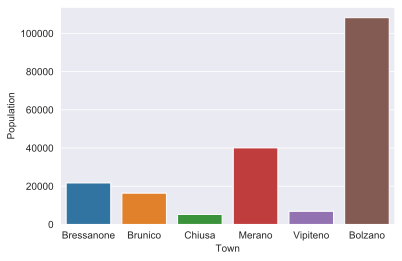

In [30]:
# Plot population in towns

sns.set_style('darkgrid')
sns.barplot(coords['Town'], coords['Population'])
ppl.set_ylabel('')
ppl.set_title(label='Population', fontsize=20)
ppl.set_xlabel('')
ppl.tick_params(labelsize=12, width=5)
ppl.set_xticklabels(coords['Town'].values, rotation=45)

## This makes me think that it would be nice to take into consideration the difference in town population and yet quite normal distribution of registered venues on Foursquare. In a small town like Chiusa it seems more significant to have a registered venue while in Bolzano it's of a less impact.
## So we introduce correction factors:
## 1) based on quantity of venues registered on Foursquare.
## 2) based on population. 

## Correction factor 1 - Foursquare data

In [31]:
# Correction factor for BRESSANONE and CHIUSA:
# Check for intersection of hotel names:
df_chiusa = df[df['Town']=='Chiusa']
df_bressanone = df[df['Town']=='Bressanone']
dfj = df_bressanone['Venue']
dfk = df_chiusa['Venue']

# Define correction factor
bressanone_correction_factor = (len(dfj))/((len(dfj)+len(dfk)))
chiusa_correction_factor = ((len(dfk))/((len(dfj)+len(dfk))))
print('Bressanone correction factor: {}/({}+{}) = '.format(len(dfj), len(dfj), len(dfk)), bressanone_correction_factor)
print('Chiusa correction factor: {}/({}+{}) = '.format(len(dfk), len(dfj), len(dfk)), chiusa_correction_factor)

Bressanone correction factor: 76/(76+35) =  0.6846846846846847
Chiusa correction factor: 35/(76+35) =  0.3153153153153153


## Correction factor 2 - Population

In [32]:
# 2) Population factor (Normalized data by population) 
col = []
for item in range(len(coords['Population'])):
    x = 1-(coords.iat[item,3] - min(coords['Population'].values))/(max(coords['Population'].values)-min(coords['Population'].values))
    col.append(x)
coords['Pop_coef'] = col
# Replace coefficients of [1, 0] by [0, 1]
# dfn1.replace(to_replace=[1,0], value=[0, 1], inplace=True) 
print('Population-based factor in the last column:')
coords

Population-based factor in the last column:


Town   Latitude  Longitude  Population  Pop_coef
0  Bressanone  46.715030   11.65598       21688  0.840115
1     Brunico  46.799420   11.93429       16356  0.891866
2      Chiusa  46.639924   11.56635        5215  1.000000
3      Merano  46.668170   11.15953       40047  0.661924
4    Vipiteno  46.893130   11.42961        6875  0.983888
5     Bolzano  46.500000   11.35000      108245  0.000000

## Leader countries of visitors

Who is visiting most?:


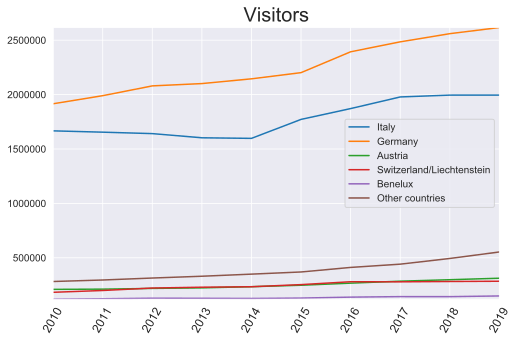

In [33]:
dfg = pd.read_excel('Per origin trend.xls')
dfg.drop(columns=['Italia.1', 'Germania.1', 
       'Austria.1', 'Svizzera e Liechtenstein.1',
       'Benelux.1', 'Altri paesi.1', 'Totale', 'Totale.1'], axis=1, inplace=True)
dfg.drop(0, axis=0, inplace=True)
dfg.rename(columns={'Italia':'Italy', 'Germania':'Germany',
                    'Gruppi di nazioni':'Year',
                    'Svizzera e Liechtenstein':'Switzerland/Liechtenstein',
                    'Altri paesi':'Other countries'}, inplace=True)
dfg.reset_index()
dfg = dfg.apply(pd.to_numeric, errors='coerce')
dfg.set_index('Year', inplace=True)
print('Who is visiting most?:')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5
ax = sns.lineplot(data=dfg, dashes=False)
ax.margins(0)
ax.set_xticklabels(range(2010, 2020), rotation=60, fontsize=12)
ax.set_xlabel('')
ax.set_title('Visitors', fontsize=20)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

### Italian and German tourists are the most numerous. We can see also who is checking in the top level hotels and in where

## Preference of hotel by nationality

What hotels do they check-in?


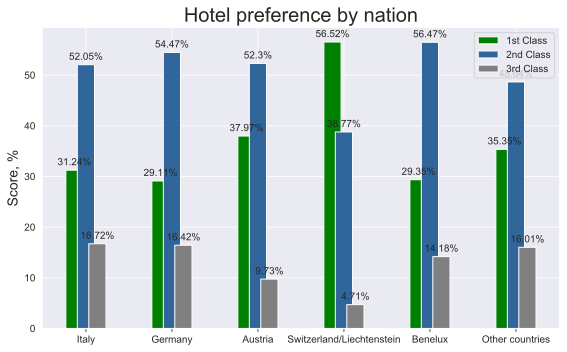

In [34]:
dfe = pd.read_excel('Per origin-hotel.xls')
dfe
dfe.drop(columns=['Unnamed: 0','Italia.1', 'Germania.1', 
       'Austria.1', 'Svizzera e Liechtenstein.1',
       'Benelux.1', 'Altri paesi.1', 'Totale', 'Totale.1'], axis=1, inplace=True)
dfe.drop([0,4,5,6,7,8,9,10,11], axis=0, inplace=True)
dfe.rename(columns={'Italia':'Italy', 'Germania':'Germany',
                    'Gruppi di nazioni':'Class',
                    'Svizzera e Liechtenstein':'Switzerland/Liechtenstein',
                    'Altri paesi':'Other countries'}, inplace=True)
dfe = dfe.apply(pd.to_numeric, errors='coerce')
dfe['Class'] = [1,2,3]
print('What hotels do they check-in?')
%matplotlib inline
# Plot the table
raw_data = dfe.iloc[:, 1:7]
labels = raw_data.columns.values
first = []
second = []
third = []
tot = []
total = [first, second, third, tot]

for j in range(len(raw_data.columns)): 
    tot.append(raw_data.iloc[:,j].values.sum())
    for val in range(len(raw_data.index)):
        total[val].append(raw_data.iat[val,j]/tot[j]*100)


x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
rcParams['figure.figsize'] = 8,5

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/3, first, width, label='1st Class', color='green')
rects2 = ax.bar(x, second, width, label='2nd Class', color='#30669a')
rects3 = ax.bar(x + 2*width/3, third, width, label='3rd Class', color='grey')


# Add labels, title, custom x-axis tick labels, etc.
ax.set_ylabel('Score, %', fontsize=14)
ax.set_title('Hotel preference by nation', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height().round(2)
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

## How long is the typical stay in hotel by nation

How long do they stay?


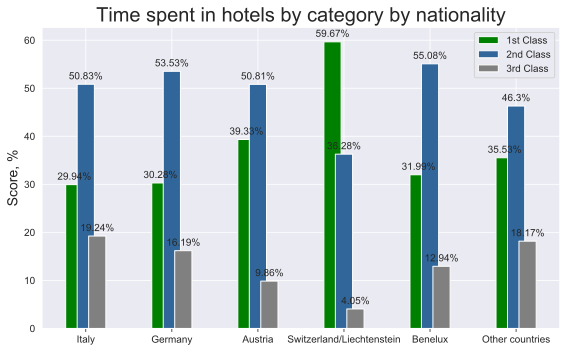

In [36]:
dff = pd.read_excel('Per origin-hotel.xls')
dff
dff.drop(columns=['Unnamed: 0','Italia', 'Germania', 
       'Austria', 'Svizzera e Liechtenstein',
       'Benelux', 'Altri paesi', 'Totale', 'Totale'], axis=1, inplace=True)
dff.drop([0,4,5,6,7,8,9,10,11], axis=0, inplace=True)
dff.rename(columns={'Italia.1':'Italy', 'Germania.1':'Germany',
                    'Gruppi di nazioni':'Class',
                    'Svizzera e Liechtenstein.1':'Switzerland/Liechtenstein',
                    'Altri paesi.1':'Other countries',
                    'Austria.1':'Austria', 
                    'Benelux.1':'Benelux'}, inplace=True)
dff = dff.apply(pd.to_numeric, errors='coerce')
dff['Class'] = [1,2,3]
print('How long do they stay?')
# Plot the table
raw_data = dff.iloc[:, 1:7]
labels = raw_data.columns.values
first = []
second = []
third = []
tot = []
total = [first, second, third, tot]

for j in range(len(raw_data.columns)): 
    tot.append(raw_data.iloc[:,j].values.sum())
    for val in range(len(raw_data.index)):
        total[val].append(raw_data.iat[val,j]/tot[j]*100)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width/3, first, width, label='1st Class', color='green')
rects2 = ax.bar(x, second, width, label='2nd Class', color='#30669a')
rects3 = ax.bar(x + 2*width/3, third, width, label='3rd Class', color='grey')


# Add labels, title, custom x-axis tick labels, etc.
ax.set_ylabel('Score, %', fontsize=14)
ax.set_title('Time spent in hotels by category by nationality', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height().round(2)
        ax.annotate('{}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig('time_in_hotels.png', dpi=300)
plt.show()

# Distribution of hotels

This is how hotels are located. Merano is clear leader in every aspect.


Text(0.5, 1.0, 'Distribution of hotels')

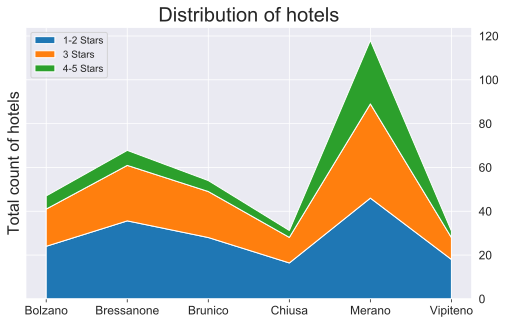

In [37]:
# Load data
dfa = pd.read_excel('Receiving capacity and beds per category per territory.xls')
# CLEANING UP data
# Replacing 'community' name with 'town' name
dfa.replace(to_replace=['Alta Valle Isarco', 'Burgraviato', 'Val Pusteria', 'Valle Isarco'], 
                  value=['Vipiteno', 'Merano', 'Brunico', 'Chiusa'], inplace=True)

# Adding row for Bressanone

dfa = dfa.append(dfa.loc[6, :], ignore_index=True)
dfa.loc[7, 'Tipologia'] = 'Bressanone'
dfa.drop(1, axis=0, inplace=True)

# Dropping unnecesssary columns

dfa.drop(['Totale', 'Totale.1', 'Esercizi extralberghieri.6', 'Esercizi extralberghieri.7',
        'Esercizi extralberghieri.8', 'Esercizi extralberghieri.9', 'Esercizi alberghieri.8', 
          'Esercizi alberghieri.9', 'Esercizi extralberghieri.2', 'Esercizi extralberghieri.3', 
          'Esercizi alberghieri.1', 'Esercizi alberghieri.3', 'Esercizi alberghieri.5', 
          'Esercizi alberghieri.7', 'Esercizi extralberghieri.1', 'Esercizi extralberghieri.5'], 
         axis=1, inplace=True)
# Make row 0 to be the column names
dfa.columns = dfa.loc[0, :]
dfa.drop(0, inplace=True)

# Set all to numeric format

dfa1 = dfa.apply(pd.to_numeric, errors='coerce')
dfa1['Categoria'] = dfa['Categoria']
dfa1.reset_index(inplace=True)
dfa1.drop('index', axis=1, inplace=True)

# Apply correction factor

dfa1.iloc[4,1:] = dfa1.loc[4][1:]*chiusa_correction_factor
dfa1.iloc[5,1:] = dfa1.loc[5][1:]*bressanone_correction_factor

dfa1.drop(columns=['Residence', 'Campeggi', 'Esercizi agrituristici'], axis=1, inplace=True)
dfa1.rename(columns={'4-5 Stelle':'4-5 Stars', '3 Stelle':'3 Stars', '1-2 Stelle':'1-2 Stars'}, inplace=True)

# Nan to zero
dfa1.fillna(value=0, inplace=True)
print('This is how hotels are located. Merano is clear leader in every aspect.')

# Merge with DataFrame
df_complete = pd.merge(df, dfa1, left_on='Town', right_on='Categoria', how='outer')
df_complete.drop(columns='Categoria', axis=1, inplace=True)

# Plot types of hotels
dfa1.sort_values(by='Categoria', inplace=True)
x = dfa1['Categoria'].values
y3 = dfa1['4-5 Stars'].values
y2 = dfa1['3 Stars'].values
y1 = dfa1['1-2 Stars'].values
lab=dfa1.columns.difference(['Categoria']).values
ax = plt.stackplot(x, y1,y2,y3, labels=lab, baseline='zero')
plt.legend(loc='upper left')
plt.ylabel('Total count of hotels', fontsize=16)
plt.tick_params(labelsize=12, labelright=True, labelleft=False)
plt.title('Distribution of hotels', loc='center', fontsize=20)

Text(0.5, 1.0, 'Distribution of hotels')

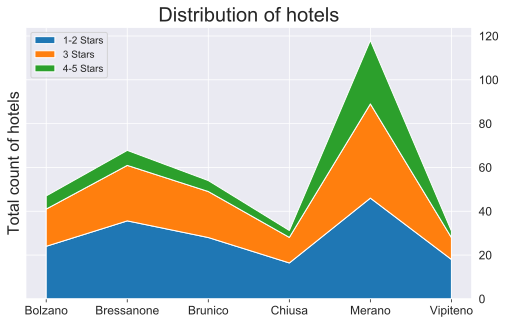

In [39]:
ax = plt.stackplot(x, y1,y2,y3, labels=lab, baseline='zero')
plt.legend(loc='upper left')
plt.ylabel('Total count of hotels', fontsize=16)
plt.tick_params(labelsize=12, labelright=True, labelleft=False)
plt.title('Distribution of hotels', loc='center', fontsize=20)

### We can check ratios of a hotel category of our interest to total amount of hotels:

This is the ratio of hotel category to total quantity of hotels. 
Again, Merano is a leader


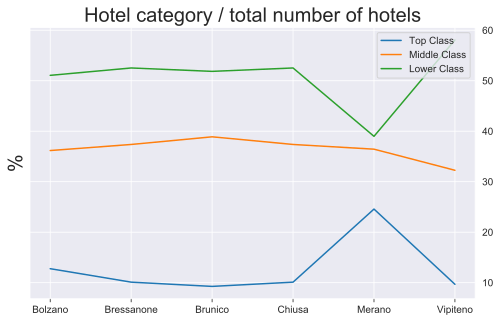

In [40]:
# Ratio of top level hotels to total number of hotels by town:
dfa1.reset_index(inplace=True)
dfa1.drop(columns='index', axis=1, inplace=True)
#dfa1.drop(columns='level_0', axis=1, inplace=True)
ratio = []
for row in range(0, len(dfa1)):
    part = []
    for col in range(1, len(dfa1.columns)):
        k = (dfa1.iat[row,col]) / (dfa1.iloc[row, 1:len(dfa1.columns)].sum())*100
        part.append(k)
    ratio.append(part)
Top_to_total = []
Med_to_total = []
Low_to_total = []
for i in range(0, len(ratio)):
    Top_to_total.append(ratio[i][0])
for i in range(0, len(ratio)):
    Med_to_total.append(ratio[i][1])
for i in range(0, len(ratio)):
    Low_to_total.append(ratio[i][2])

dfa1['Top Class'] = Top_to_total
dfa1['Middle Class'] = Med_to_total
dfa1['Lower Class'] = Low_to_total


# Plot ratio
ax2 = sns.lineplot(data=dfa1.loc[:, ['Top Class','Middle Class','Lower Class']], dashes=False)
ax2.set_xticks(dfa1.index)
ax2.set_xticklabels(dfa1['Categoria'])
ax2.tick_params(labelright=True, labelleft=False)
ax2.set_ylabel('%', fontsize=20, rotation=90)
ax2.set_title('Hotel category / total number of hotels', fontsize=20)
print('This is the ratio of hotel category to total quantity of hotels. \nAgain, Merano is a leader')

### We can check ratios of a hotel category of our interest to other categories:

Text(0.5, 1.0, 'Top category / given category')

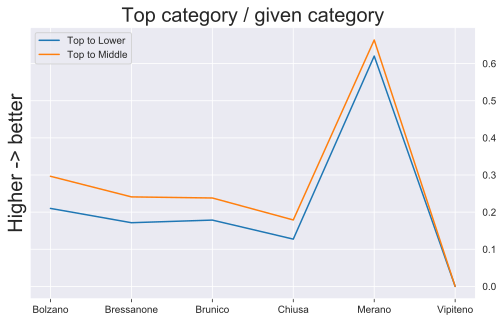

In [41]:
# Ratio of top level hotels to total number of hotels by town:
dfa1.reset_index(inplace=True)
dfa1.drop(columns='index', axis=1, inplace=True)
#dfa1.drop(columns='level_0', axis=1, inplace=True)
ratio = []
for row in range(0, len(dfa1)):
    luxury = []
    for col in range(2, len(dfa1.columns)):
        k =  dfa1.iat[row,1] / dfa1.iat[row,col]
        luxury.append(k)
    ratio.append(luxury)
Top_to_lower = []
Top_to_middle = []
for i in range(0, len(ratio)):
    Top_to_lower.append(ratio[i][1])
for i in range(0, len(ratio)):
    Top_to_middle.append(ratio[i][0])

dfa1['Top to Lower'] = Top_to_lower*coords['Pop_coef']
dfa1['Top to Middle'] = Top_to_middle*coords['Pop_coef']

# Plot ratio
ax2 = sns.lineplot(data=dfa1.loc[:, ['Top to Lower','Top to Middle']], dashes=False)
ax2.set_xticks(dfa1.index)
ax2.set_xticklabels(dfa1['Categoria'])
ax2.tick_params(labelright=True, labelleft=False)
ax2.set_ylabel('Higher -> better', fontsize=20, rotation=90)
ax2.set_title('Top category / given category', fontsize=20)

## Ok, now we can see that the 2nd place after Merano is Chiusa. The ratio Top level / Lower level is the highest after Merano.

# Preference of Town by nationality

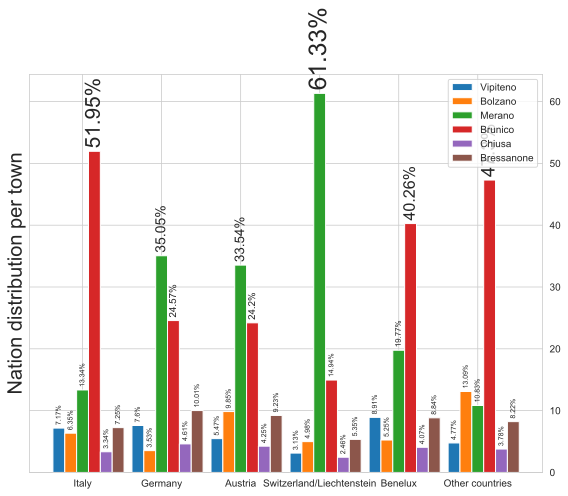

In [47]:
dfc = pd.read_excel('Per origin-territory.xls')

dfc.drop(['Italia.1', 'Germania.1',
       'Austria.1', 'Svizzera e Liechtenstein.1',
       'Benelux.1', 'Altri paesi.1', 'Totale', 'Totale.1'], axis=1, inplace=True)
dfc.drop([0,4], axis=0, inplace=True)

dfc.replace(to_replace=['Alta Valle Isarco', 'Burgraviato', 'Val Pusteria', 'Valle Isarco'], 
                  value=['Vipiteno', 'Merano', 'Brunico', 'Chiusa'], inplace=True)
dfc.rename(columns={'Italia':'Italy', 'Germania':'Germany', 
                    'Svizzera e Liechtenstein':'Switzerland/Liechtenstein', 
                    'Altri paesi':'Other countries',
                    'Gruppi di nazioni':'Town'}, inplace=True)
dfc.loc[7, :] = dfc.loc[6, :]
dfc.loc[7, 'Town'] = 'Bressanone'

rcParams['figure.figsize'] = 8,7
raw_data = dfc.iloc[:, 1:7]
labels = raw_data.columns.values
vipiteno = []
bolzano = []
merano = []
brunico = []
chiusa = []
chiusa_corrected = []
bressanone_corrected = []
bressanone = []
tot = []
total = [vipiteno, bolzano, merano, brunico, chiusa, bressanone, tot]

for j in range(len(raw_data.columns)): 
    tot.append(raw_data.iloc[:,j].values.sum())
    for val in range(len(raw_data.index)):
        total[val].append(raw_data.iat[val,j]/tot[j]*100)

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

# Applying correction factor

for item in chiusa:
    chiusa_corrected.append(item*chiusa_correction_factor)
for item in bressanone:
    bressanone_corrected.append(item*bressanone_correction_factor)

# Plot
sns.set_style("whitegrid")
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, vipiteno, width, label='Vipiteno')
rects2 = ax.bar(x - width, bolzano, width, label='Bolzano')
rects3 = ax.bar(x, merano, width, label='Merano')
rects4 = ax.bar(x + width, brunico, width, label='Brunico')
rects5 = ax.bar(x + 2*width, chiusa_corrected, width, label='Chiusa')
rects6 = ax.bar(x + 3*width, bressanone_corrected, width, label='Bressanone')



# Add labels, title, custom x-axis tick labels, etc.
ax.set_ylabel('Nation distribution per town', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(labelleft=False, labelright=True)
ax.legend(loc='best')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height().round(2)
        ax.annotate('{}%'.format(height), rotation=90,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize = 0.4*height if height>15 else 7)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

fig.tight_layout()
plt.show()

In [48]:
# Preparing complete Dataframe with official data
dfc = pd.read_excel('Per origin-territory.xls')
dfc.drop(['Italia.1', 'Germania.1',
       'Austria.1', 'Svizzera e Liechtenstein.1',
       'Benelux.1', 'Altri paesi.1', 'Totale', 'Totale.1'], axis=1, inplace=True)
dfc.drop([0,4], axis=0, inplace=True)

dfc.replace(to_replace=['Alta Valle Isarco', 'Burgraviato', 'Val Pusteria', 'Valle Isarco'], 
                  value=['Vipiteno', 'Merano', 'Brunico', 'Chiusa'], inplace=True)

# Adding row for Bressanone

dfc.loc[7, :] = dfc.loc[6, :]
dfc.loc[7, 'Gruppi di nazioni'] = 'Bressanone'


# Final Dataframe
df_complete = pd.merge(coords, dfc, left_on='Town', right_on='Gruppi di nazioni', how='outer')
df_complete.drop(columns='Gruppi di nazioni', axis=1, inplace=True)
df_complete.rename(columns={'Italia':'Italy', 'Germania':'Germany', 
                            'Svizzera e Liechtenstein':'Switzerland/Liechtenstein', 
                            'Altri paesi':'Other countries'}, inplace=True)

df_complete = pd.merge(df_complete, dfa1, left_on='Town', right_on='Categoria', how='outer')
df_complete.drop(columns='Categoria', axis=1, inplace=True)
df_complete.drop(columns=['Top Class', 'Middle Class', 'Lower Class'], axis=1, inplace=True)

df_complete

Town   Latitude  Longitude  Population  Pop_coef    Italy  Germany  \
0  Bressanone  46.715030   11.65598       21688  0.840115  1990602  3362920   
1     Brunico  46.799420   11.93429       16356  0.891866  9764608  5650280   
2      Chiusa  46.639924   11.56635        5215  1.000000  1990602  3362920   
3      Merano  46.668170   11.15953       40047  0.661924  2506803  8059669   
4    Vipiteno  46.893130   11.42961        6875  0.983888  1348197  1746925   
5     Bolzano  46.500000   11.35000      108245  0.000000  1193808   811689   

   Austria  Switzerland/Liechtenstein  Benelux  Other countries  4-5 Stars  \
0   321681                     180753   176341           486333   6.846847   
1   577702                     345859   550194          1916418   5.000000   
2   321681                     180753   176341           486333   3.153153   
3   800702                    1419334   270094           438900  29.000000   
4   130509                      72487   121783           193289   3.000000   
5   235169                     115192    71683           530389   6.000000   

     3 Stars  1-2 Stars  Top to Lower  Top to Middle  
0  25.333333  35.603604      0.171513       0.241045  
1  21.000000  28.000000      0.178571       0.238095  
2  11.666667  16.396396      0.127293       0.178898  
3  43.000000  46.000000      0.620277       0.663552  
4  10.000000  18.000000      0.000000       0.000000  
5  17.000000  24.000000      0.210029       0.296511


___________________________________________________________________________________________

# Machine learning

## *Feature engineering*

In [49]:
# importing libraries
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


# Dataset for target: 'Town' 
dfcopy = df_complete.copy()
# Making a numeric column for Town
X = dfcopy.drop(['Latitude', 'Longitude', 'Town'], axis=1)   #Feature Matrix
y = dfcopy["Town"]          #Target Variable

from sklearn import preprocessing

# Preprocessing: categorical to numeric
lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)
X

Population  Pop_coef    Italy  Germany  Austria  Switzerland/Liechtenstein  \
0       21688  0.840115  1990602  3362920   321681                     180753   
1       16356  0.891866  9764608  5650280   577702                     345859   
2        5215  1.000000  1990602  3362920   321681                     180753   
3       40047  0.661924  2506803  8059669   800702                    1419334   
4        6875  0.983888  1348197  1746925   130509                      72487   
5      108245  0.000000  1193808   811689   235169                     115192   

   Benelux  Other countries  4-5 Stars    3 Stars  1-2 Stars  Top to Lower  \
0   176341           486333   6.846847  25.333333  35.603604      0.171513   
1   550194          1916418   5.000000  21.000000  28.000000      0.178571   
2   176341           486333   3.153153  11.666667  16.396396      0.127293   
3   270094           438900  29.000000  43.000000  46.000000      0.620277   
4   121783           193289   3.000000  10.000000  18.000000      0.000000   
5    71683           530389   6.000000  17.000000  24.000000      0.210029   

   Top to Middle  
0       0.241045  
1       0.238095  
2       0.178898  
3       0.663552  
4       0.000000  
5       0.296511

## Most important features correlating with 1st class hotels

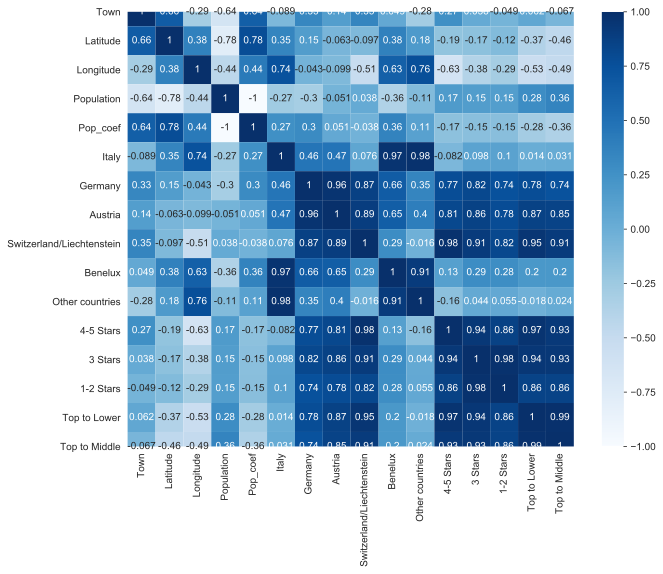

In [51]:
#Using Pearson Correlation
plt.figure(figsize=(10,8))
dfcopy['Town'] = lab_enc.fit_transform(dfcopy['Town'])
cor = dfcopy.corr(method='pearson')
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.savefig('Pearson.png')
plt.show()

In [52]:
#Correlation with output variable

cor_target = abs(cor["4-5 Stars"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.7]
print('Most correlation found in features according to Pearson analysis: ')
relevant_features.drop('4-5 Stars').sort_values(ascending=False).head(7)

Most correlation found in features according to Pearson analysis: 


Switzerland/Liechtenstein    0.977835
Top to Lower                 0.966605
3 Stars                      0.935580
Top to Middle                0.928036
1-2 Stars                    0.860044
Austria                      0.814326
Germany                      0.774899
Name: 4-5 Stars, dtype: float64

In [53]:
# Drop irrelevent columns from the Dataframe
dfcopy.drop(columns=['Town', 'Latitude', 'Longitude', 'Population', 'Pop_coef',
       '4-5 Stars', 'Italy', 'Benelux', 'Other countries'], axis=1, inplace=True)
print('Dataframe with only relevant features:')
dfcopy

Dataframe with only relevant features:


Germany  Austria  Switzerland/Liechtenstein    3 Stars  1-2 Stars  \
0  3362920   321681                     180753  25.333333  35.603604   
1  5650280   577702                     345859  21.000000  28.000000   
2  3362920   321681                     180753  11.666667  16.396396   
3  8059669   800702                    1419334  43.000000  46.000000   
4  1746925   130509                      72487  10.000000  18.000000   
5   811689   235169                     115192  17.000000  24.000000   

   Top to Lower  Top to Middle  
0      0.171513       0.241045  
1      0.178571       0.238095  
2      0.127293       0.178898  
3      0.620277       0.663552  
4      0.000000       0.000000  
5      0.210029       0.296511

In [54]:
# Unsupervised clustering
# Algorithms are capable to take care of the fact of manually splitting Bressanone and Chiusa
# i.e. they recognize their linear dependence.


from sklearn.cluster import AgglomerativeClustering

# Cluster towns in 4 categories
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
clustering.fit_predict(dfcopy)
clustering.labels_

array([2, 0, 2, 0, 1, 1])

In [55]:
from sklearn.cluster import KMeans

clust = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=None)
clust.fit_predict(dfcopy)
clust.labels_

array([2, 1, 2, 1, 0, 0], dtype=int32)

In [56]:
dfresults = pd.DataFrame({'Town': df_complete['Town'].values, 
                          'Agglomerative Clustering': clustering.labels_, 
                          'KMeans':clust.labels_})
print('Verifying that 2 different algorithms clusterize towns in a similar way.\nIt confirmes that Brunico and Merano are in the same cluster')
dfresults

Verifying that 2 different algorithms clusterize towns in a similar way.
It confirmes that Brunico and Merano are in the same cluster


Town  Agglomerative Clustering  KMeans
0  Bressanone                         2       2
1     Brunico                         0       1
2      Chiusa                         2       2
3      Merano                         0       1
4    Vipiteno                         1       0
5     Bolzano                         1       0

## Now take a look back on the map

In [57]:
print('We got: \n'+str(len(dfhotel['Town']))+' hotels in the observed region (blue)')
print(str(len(dffood['Venue']))+' food related venues (green)')
print(str(len(dfdrink['Venue']))+' drink related venues (red)')
print(str(len(dfcafe['Venue']))+' cafeteria venues (pink)')
print(str(len(dftourist['Venue']))+'  touristic venues (orange)')
print(str(len(dfother['Venue']))+' other kind of venues (grey)')

map

We got: 
220 hotels in the observed region (blue)
225 food related venues (green)
17 drink related venues (red)
56 cafeteria venues (pink)
43  touristic venues (orange)
107 other kind of venues (grey)


## We can define purely geographic criteria of positioning. It will be a center of venues for each town. We find centroid of points for each category of venues, like hotels, restaurants, ski, etc. Then we assign importance on each category based on our client requests and find centroid of centroids. This will be the perfect spot.

In [58]:
x_food = dffood.loc[:,['Latitude', 'Longitude', 'Town']]
x_food_bressanone = x_food.copy().loc[x_food['Town']=='Bressanone', :]
x_food_bressanone.drop(columns='Town', axis=1, inplace=True)
X_food_bressanone = list(zip(x_food_bressanone['Latitude'], x_food_bressanone['Longitude']))

x_food_brunico = x_food.copy().loc[x_food['Town']=='Brunico', :]
x_food_brunico.drop(columns='Town', axis=1, inplace=True)
X_food_brunico = list(zip(x_food_brunico['Latitude'], x_food_brunico['Longitude']))

x_food_chiusa = x_food.copy().loc[x_food['Town']=='Chiusa', :]
x_food_chiusa.drop(columns='Town', axis=1, inplace=True)
X_food_chiusa = list(zip(x_food_chiusa['Latitude'], x_food_chiusa['Longitude']))

x_food_merano = x_food.copy().loc[x_food['Town']=='Merano', :]
x_food_merano.drop(columns='Town', axis=1, inplace=True)
X_food_merano = list(zip(x_food_merano['Latitude'], x_food_merano['Longitude']))

x_food_vipiteno = x_food.copy().loc[x_food['Town']=='Vipiteno', :]
x_food_vipiteno.drop(columns='Town', axis=1, inplace=True)
X_food_vipiteno = list(zip(x_food_vipiteno['Latitude'], x_food_vipiteno['Longitude']))

x_food_bolzano = x_food.copy().loc[x_food['Town']=='Bolzano', :]
x_food_bolzano.drop(columns='Town', axis=1, inplace=True)
X_food_bolzano = list(zip(x_food_bolzano['Latitude'], x_food_bolzano['Longitude']))


x_drink = dfdrink.loc[:,['Latitude', 'Longitude', 'Town']]
x_drink_bressanone = x_drink.copy().loc[x_drink['Town']=='Bressanone', :]
x_drink_bressanone.drop(columns='Town', axis=1, inplace=True)
X_drink_bressanone = list(zip(x_drink_bressanone['Latitude'], x_drink_bressanone['Longitude']))

x_drink_brunico = x_drink.copy().loc[x_drink['Town']=='Brunico', :]
x_drink_brunico.drop(columns='Town', axis=1, inplace=True)
X_drink_brunico = list(zip(x_drink_brunico['Latitude'], x_drink_brunico['Longitude']))

x_drink_chiusa = x_drink.copy().loc[x_drink['Town']=='Chiusa', :]
x_drink_chiusa.drop(columns='Town', axis=1, inplace=True)
X_drink_chiusa = list(zip(x_drink_chiusa['Latitude'], x_drink_chiusa['Longitude']))

x_drink_merano = x_drink.copy().loc[x_drink['Town']=='Merano', :]
x_drink_merano.drop(columns='Town', axis=1, inplace=True)
X_drink_merano = list(zip(x_drink_merano['Latitude'], x_drink_merano['Longitude']))

x_drink_vipiteno = x_drink.copy().loc[x_drink['Town']=='Vipiteno', :]
x_drink_vipiteno.drop(columns='Town', axis=1, inplace=True)
X_drink_vipiteno = list(zip(x_drink_vipiteno['Latitude'], x_drink_vipiteno['Longitude']))

x_drink_bolzano = x_drink.copy().loc[x_drink['Town']=='Bolzano', :]
x_drink_bolzano.drop(columns='Town', axis=1, inplace=True)
X_drink_bolzano = list(zip(x_drink_bolzano['Latitude'], x_drink_bolzano['Longitude']))


x_hotel = dfhotel.loc[:,['Latitude', 'Longitude', 'Town']]
x_hotel_bressanone = x_hotel.copy().loc[x_hotel['Town']=='Bressanone', :]
x_hotel_bressanone.drop(columns='Town', axis=1, inplace=True)
X_hotel_bressanone = list(zip(x_hotel_bressanone['Latitude'], x_hotel_bressanone['Longitude']))

x_hotel_brunico = x_hotel.copy().loc[x_hotel['Town']=='Brunico', :]
x_hotel_brunico.drop(columns='Town', axis=1, inplace=True)
X_hotel_brunico = list(zip(x_hotel_brunico['Latitude'], x_hotel_brunico['Longitude']))

x_hotel_chiusa = x_hotel.copy().loc[x_hotel['Town']=='Chiusa', :]
x_hotel_chiusa.drop(columns='Town', axis=1, inplace=True)
X_hotel_chiusa = list(zip(x_hotel_chiusa['Latitude'], x_hotel_chiusa['Longitude']))

x_hotel_merano = x_hotel.copy().loc[x_hotel['Town']=='Merano', :]
x_hotel_merano.drop(columns='Town', axis=1, inplace=True)
X_hotel_merano = list(zip(x_hotel_merano['Latitude'], x_hotel_merano['Longitude']))

x_hotel_vipiteno = x_hotel.copy().loc[x_hotel['Town']=='Vipiteno', :]
x_hotel_vipiteno.drop(columns='Town', axis=1, inplace=True)
X_hotel_vipiteno = list(zip(x_hotel_vipiteno['Latitude'], x_hotel_vipiteno['Longitude']))

x_hotel_bolzano = x_hotel.copy().loc[x_hotel['Town']=='Bolzano', :]
x_hotel_bolzano.drop(columns='Town', axis=1, inplace=True)
X_hotel_bolzano = list(zip(x_hotel_bolzano['Latitude'], x_hotel_bolzano['Longitude']))


x_cafe = dfcafe.loc[:,['Latitude', 'Longitude', 'Town']]
x_cafe_bressanone = x_cafe.copy().loc[x_cafe['Town']=='Bressanone', :]
x_cafe_bressanone.drop(columns='Town', axis=1, inplace=True)
X_cafe_bressanone = list(zip(x_cafe_bressanone['Latitude'], x_cafe_bressanone['Longitude']))

x_cafe_brunico = x_cafe.copy().loc[x_cafe['Town']=='Brunico', :]
x_cafe_brunico.drop(columns='Town', axis=1, inplace=True)
X_cafe_brunico = list(zip(x_cafe_brunico['Latitude'], x_cafe_brunico['Longitude']))

x_cafe_chiusa = x_cafe.copy().loc[x_cafe['Town']=='Chiusa', :]
x_cafe_chiusa.drop(columns='Town', axis=1, inplace=True)
X_cafe_chiusa = list(zip(x_cafe_chiusa['Latitude'], x_cafe_chiusa['Longitude']))

x_cafe_merano = x_cafe.copy().loc[x_cafe['Town']=='Merano', :]
x_cafe_merano.drop(columns='Town', axis=1, inplace=True)
X_cafe_merano = list(zip(x_cafe_merano['Latitude'], x_cafe_merano['Longitude']))

x_cafe_vipiteno = x_cafe.copy().loc[x_cafe['Town']=='Vipiteno', :]
x_cafe_vipiteno.drop(columns='Town', axis=1, inplace=True)
X_cafe_vipiteno = list(zip(x_cafe_vipiteno['Latitude'], x_cafe_vipiteno['Longitude']))

x_cafe_bolzano = x_cafe.copy().loc[x_cafe['Town']=='Bolzano', :]
x_cafe_bolzano.drop(columns='Town', axis=1, inplace=True)
X_cafe_bolzano = list(zip(x_cafe_bolzano['Latitude'], x_cafe_bolzano['Longitude']))


x_tourist = dftourist.loc[:,['Latitude', 'Longitude', 'Town']]
x_tourist_bressanone = x_tourist.copy().loc[x_tourist['Town']=='Bressanone', :]
x_tourist_bressanone.drop(columns='Town', axis=1, inplace=True)
X_tourist_bressanone = list(zip(x_tourist_bressanone['Latitude'], x_tourist_bressanone['Longitude']))

x_tourist_brunico = x_tourist.copy().loc[x_tourist['Town']=='Brunico', :]
x_tourist_brunico.drop(columns='Town', axis=1, inplace=True)
X_tourist_brunico = list(zip(x_tourist_brunico['Latitude'], x_tourist_brunico['Longitude']))

x_tourist_chiusa = x_tourist.copy().loc[x_tourist['Town']=='Chiusa', :]
x_tourist_chiusa.drop(columns='Town', axis=1, inplace=True)
X_tourist_chiusa = list(zip(x_tourist_chiusa['Latitude'], x_tourist_chiusa['Longitude']))

x_tourist_merano = x_tourist.copy().loc[x_tourist['Town']=='Merano', :]
x_tourist_merano.drop(columns='Town', axis=1, inplace=True)
X_tourist_merano = list(zip(x_tourist_merano['Latitude'], x_tourist_merano['Longitude']))

x_tourist_vipiteno = x_tourist.copy().loc[x_tourist['Town']=='Vipiteno', :]
x_tourist_vipiteno.drop(columns='Town', axis=1, inplace=True)
X_tourist_vipiteno = list(zip(x_tourist_vipiteno['Latitude'], x_tourist_vipiteno['Longitude']))

x_tourist_bolzano = x_tourist.copy().loc[x_tourist['Town']=='Bolzano', :]
x_tourist_bolzano.drop(columns='Town', axis=1, inplace=True)
X_tourist_bolzano = list(zip(x_tourist_bolzano['Latitude'], x_tourist_bolzano['Longitude']))


x_other = dfother.loc[:,['Latitude', 'Longitude', 'Town']]
x_other_bressanone = x_other.copy().loc[x_other['Town']=='Bressanone', :]
x_other_bressanone.drop(columns='Town', axis=1, inplace=True)
X_other_bressanone = list(zip(x_other_bressanone['Latitude'], x_other_bressanone['Longitude']))

x_other_brunico = x_other.copy().loc[x_other['Town']=='Brunico', :]
x_other_brunico.drop(columns='Town', axis=1, inplace=True)
X_other_brunico = list(zip(x_other_brunico['Latitude'], x_other_brunico['Longitude']))

x_other_chiusa = x_other.copy().loc[x_other['Town']=='Chiusa', :]
x_other_chiusa.drop(columns='Town', axis=1, inplace=True)
X_other_chiusa = list(zip(x_other_chiusa['Latitude'], x_other_chiusa['Longitude']))

x_other_merano = x_other.copy().loc[x_other['Town']=='Merano', :]
x_other_merano.drop(columns='Town', axis=1, inplace=True)
X_other_merano = list(zip(x_other_merano['Latitude'], x_other_merano['Longitude']))

x_other_vipiteno = x_other.copy().loc[x_other['Town']=='Vipiteno', :]
x_other_vipiteno.drop(columns='Town', axis=1, inplace=True)
X_other_vipiteno = list(zip(x_other_vipiteno['Latitude'], x_other_vipiteno['Longitude']))

x_other_bolzano = x_other.copy().loc[x_other['Town']=='Bolzano', :]
x_other_bolzano.drop(columns='Town', axis=1, inplace=True)
X_other_bolzano = list(zip(x_other_bolzano['Latitude'], x_other_bolzano['Longitude']))

X_list_bressanone = [X_food_bressanone, X_drink_bressanone, X_hotel_bressanone, X_cafe_bressanone, X_tourist_bressanone, X_other_bressanone]
X_list_brunico = [X_food_brunico, X_drink_brunico, X_hotel_brunico, X_cafe_brunico, X_tourist_brunico, X_other_brunico]
X_list_chiusa = [X_food_chiusa, X_drink_chiusa, X_hotel_chiusa, X_cafe_chiusa, X_tourist_chiusa, X_other_chiusa]
X_list_merano = [X_food_merano, X_drink_merano, X_hotel_merano, X_cafe_merano, X_tourist_merano, X_other_merano]
X_list_vipiteno = [X_food_vipiteno, X_drink_vipiteno, X_hotel_vipiteno, X_cafe_vipiteno, X_tourist_vipiteno, X_other_vipiteno]
X_list_bolzano = [X_food_bolzano, X_drink_bolzano, X_hotel_bolzano, X_cafe_bolzano, X_tourist_bolzano, X_other_bolzano]

X_list = [X_list_bressanone, X_list_brunico, X_list_chiusa, X_list_merano, X_list_vipiteno, X_list_bolzano]

In [59]:
# Find centroids using KMEANS and color them accordingly
color_list = ['green', 'red', 'blue', 'pink', 'orange', 'grey']
color_list2 = []
for i in range(6):
    color_list2.append(color_list)
kmeans_centers_list = []
color_map = []
for j in range(len(X_list)):
    for i in range(len(X_list[j])):
        if len(X_list[j][i])==1:  
            kmeans_centers_list.append(X_list[j][i])
            color_map.append(color_list2[j][i])
            continue
        elif len(X_list[j][i])==0: 
            continue
        kmeans = KMeans(n_clusters=1, random_state=0).fit(X_list[j][i])
        kmeans_centers_list.append(kmeans.cluster_centers_)
        color_map.append(color_list2[j][i])
print("{} centroids found. Empty lists were excluded (if 0 venues in a category)".format(
    len(kmeans_centers_list)))

34 centroids found. Empty lists were excluded (if 0 venues in a category)


In [60]:
# Visualize centroids using same colormap as before for each category
map = folium.Map(location=[coords['Latitude'][0], coords['Longitude'][0]], tiles='Stamen Terrain', zoom_start=9)

for lat, lng, name in zip(dfhotel['Latitude'], dfhotel['Longitude'], dfhotel['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map)


for lat, lng, name in zip(dffood['Latitude'], dffood['Longitude'], dffood['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfdrink['Latitude'], dfdrink['Longitude'], dfdrink['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfother['Latitude'], dfother['Longitude'], dfother['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='grey',
        fill=True,
        fill_color='grey',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfcafe['Latitude'], dfcafe['Longitude'], dfcafe['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='pink',
        fill=True,
        fill_color='pink',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dftourist['Latitude'], dftourist['Longitude'], dftourist['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.2,
        parse_html=False).add_to(map)

#####

for i in range(len(kmeans_centers_list)):
    for j in range(len(kmeans_centers_list[i])):
        label = '{}'.format(name)
        label = folium.Popup(label)
        folium.CircleMarker(
        [kmeans_centers_list[i][0][0], kmeans_centers_list[i][0][1]],
        radius=10,
        #popup=label,
        color=color_map[i],
        fill=True,
        fill_opacity=0.2,
        parse_html=False).add_to(map)
map.save('categories_distribution_map.html') 
map

## Now we find "economical centroid" for every town by running another KMEANS algorithm. We will see visually what sort of venue is less present in the "economical centroid" and which are well available. It will be the final hint on what sort of venue is going to be more logical in this area

In [61]:
# Normal cluster centers
X_super = df.loc[:, ['Latitude', 'Longitude']]
df_kmeans = KMeans(n_clusters=6, random_state=0).fit(X_super)
weightless_centers = df_kmeans.cluster_centers_

# Weight = n_samples of a given category / n_samples of all categories 
weight_array = []
for j in range(len(X_list)):
    for i in range(len(X_list[j])):
        if len(X_list[j][i])==0:
            continue
        weight = round(len(X_list[j][i])/len(df[df['Town']=="{}".format(coords['Town'][j])])*100, 3)
        weight_array.append(weight)
        
# 2d array from 3d
kmeans_centers_list2 = []
for j in range(len(kmeans_centers_list)):
    kmeans_centers_list2.append(kmeans_centers_list[j][0])
    

# Weighted cluster centers   
second_kmeans_centers = KMeans(n_clusters=6, random_state=0).fit(kmeans_centers_list2, sample_weight=weight_array[0])
weighted_centers = second_kmeans_centers.cluster_centers_

In [62]:
map = folium.Map(location=[coords['Latitude'][1], coords['Longitude'][1]], tiles='Stamen Terrain', zoom_start=9)

for i in range(len(coords)):
    label = 'Geo center'
    label = folium.Popup(label)
    folium.CircleMarker(
        [coords['Latitude'][i], coords['Longitude'][i]],
        radius=4,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for i in range(len(weightless_centers)):
    label = 'Equal weight economy centroid'
    label = folium.Popup(label)
    folium.CircleMarker(
        [weightless_centers[i][0], weightless_centers[i][1]],
        radius=6,
        popup=label,
        color='white',
        fill=True,
        fill_color='white',
        fill_opacity=0.2,
        parse_html=False).add_to(map)

for i in range(len(weighted_centers)):
    label = 'Weighted economy centroid'
    label = folium.Popup(label)
    folium.CircleMarker(
        [weighted_centers[i][0], weighted_centers[i][1]],
        radius=7,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
print('See the difference between geocenter (green) vs economical center (white); \nbetween geocenter (green) vs weighted economical center (black)')
map.save('centroids_map.html') 
map

See the difference between geocenter (green) vs economical center (white); 
between geocenter (green) vs weighted economical center (black)


In [63]:
# Dataframe of weights
# Weight = n_samples of a given category / n_samples of all categories 

df_weighted = pd.DataFrame(index=range(len(coords['Town'])), columns=['Town', 'food', 'drink', 'hotel', 'cafe', 'tourist', 'other'])
for j in range(len(X_list)):
    for i in range(len(X_list[j])):
        df_weighted.iloc[j,i+1] = round((len(X_list[j][i])/len(df[df['Town']=="{}".format(coords['Town'][j])])*100), 2)
        df_weighted['Town']=coords['Town']
df_weighted_transpose = df_weighted.transpose()
df_weighted_transpose.columns = df_weighted_transpose.iloc[0]
df_weighted_transpose.drop('Town', axis=0, inplace=True)
df_weighted_transpose['Average'] = round(df_weighted_transpose.mean(axis=1), 2)
df_weighted_transpose

Town    Bressanone Brunico Chiusa Merano Vipiteno Bolzano  Average
food         27.63   21.15     40  36.81    28.89   47.24    33.62
drink         3.95    1.28   2.86   2.75     6.67    1.84     3.22
hotel        34.21   38.46     40  33.52    42.22   24.54    35.49
cafe          9.21   11.54      0   7.69     8.89    7.98     7.55
tourist       5.26   18.59      0   3.85     4.44    0.61     5.46
other        19.74   13.46  17.14  16.48    11.11    18.4    16.06

In [64]:
df_presence_percent = df_weighted_transpose.copy()
df_presence_percent.iloc[:, 0:-1] = (df_presence_percent.iloc[:, 0:-1]*100)
df_presence_percent.iloc[:, 0:-1] = df_presence_percent.mul(round(1/df_presence_percent['Average'], 2), axis=0)
df_presence_percent

Town    Bressanone Brunico  Chiusa  Merano Vipiteno Bolzano  Average
food         82.89   63.45     120  110.43    86.67  141.72    33.62
drink       122.45   39.68   88.66   85.25   206.77   57.04     3.22
hotel       102.63  115.38     120  100.56   126.66   73.62    35.49
cafe        119.73  150.02       0   99.97   115.57  103.74     7.55
tourist      94.68  334.62       0    69.3    79.92   10.98     5.46
other       118.44   80.76  102.84   98.88    66.66   110.4    16.06

In [65]:
map = folium.Map(location=[coords['Latitude'][1], coords['Longitude'][1]], tiles='Stamen Terrain', zoom_start=10.5)
for lat, lng, name in zip(dfhotel['Latitude'], dfhotel['Longitude'], dfhotel['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map)


for lat, lng, name in zip(dffood['Latitude'], dffood['Longitude'], dffood['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.8,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfdrink['Latitude'], dfdrink['Longitude'], dfdrink['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfother['Latitude'], dfother['Longitude'], dfother['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='grey',
        fill=True,
        fill_color='grey',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dfcafe['Latitude'], dfcafe['Longitude'], dfcafe['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='pink',
        fill=True,
        fill_color='pink',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for lat, lng, name in zip(dftourist['Latitude'], dftourist['Longitude'], dftourist['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.2,
        parse_html=False).add_to(map)

#####


for i in range(len(coords)):
    label = 'Geocenter'
    label = folium.Popup(label)
    folium.CircleMarker(
        [coords['Latitude'][i], coords['Longitude'][i]],
        radius=6,
        popup=label,
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.2,
        parse_html=False).add_to(map)
    
for i in range(len(weightless_centers)):
    label = 'Economy center'
    label = folium.Popup(label)
    folium.CircleMarker(
        [weightless_centers[i][0], weightless_centers[i][1]],
        radius=6,
        popup=label,
        color='white',
        fill=True,
        fill_color='white',
        fill_opacity=0.2,
        parse_html=False).add_to(map)

for i in range(len(weighted_centers)):
    label = ((((df_presence_percent.reindex(columns=['Bolzano', 'Brunico', 'Vipiteno', 'Merano', 'Bressanone', 'Chiusa']).iloc[:, i]).sort_values(ascending=True)).astype(str)+'%').to_frame()).to_html()
    label = folium.Popup(label, max_width=100,min_width='100%')
    folium.CircleMarker(
        [weighted_centers[i][0], weighted_centers[i][1]],
        radius=9,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.2,
        parse_html=True).add_to(map)
print('Click on black circle. The economy centroid is given by this percentage of venues.')
print('It makes sense to start a venue represented by smaller percent in the area close \nto the centroid')

map.save('final_map.html') 
map

Click on black circle. The economy centroid is given by this percentage of venues.
It makes sense to start a venue represented by smaller percent in the area close 
to the centroid
